In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import uuid
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [3]:
header_class = 'component_head'
table_class  = 'rt_railbox_border2'
div_class = 'SLTables1'

In [4]:
columns = ['date', 'dog', 'dog_spread_line', 'fav', 'fav_spread_line', 'ml_dog_line', 'ml_fav_line',
           'over', 'spread', 'time', 'total', 'under', 'bookie', 'game_uuid']

In [21]:
def extract_games_from_df(df, league):
    games = pd.DataFrame(columns=columns)
    successes = 0
    failures = 1
    for i in tqdm_notebook(range(len(df))):
        row = df.iloc[i, :]
        try:
            game = extract_tables_from_game(row.home_team, row.away_team, row.date_, row.uuid, league)
            games = games.append(game, ignore_index=True)
            successes += 1
        except ConnectionError:
            failures += 1
        if i % 10 == 0:
            print("Succeeded on {} of {} games so far".format(successes, successes+failures))
    print("Succeeded on {} of {} games".format(successes, successes+failures))
    return games

In [27]:
def extract_tables_from_game(home_team, away_team, date, game_uuid, league):
    url = 'http://www.vegasinsider.com/{}/odds/offshore/line-movement/{}-@-{}.cfm/date/{}'.format(league, away_team, home_team, date)
#     print(url)
    page = requests.get(url).text
    soup = BeautifulSoup(page)
    try:
        game_info = soup.find('div', class_=div_class).find_all('table')[1].find_all('tr')
        game_date = game_info[0].find('td').get_text().replace(u'\xa0', u'').split(':')[1]
        game_time = game_info[1].find('td').get_text().replace(u'\xa0', u'').split('e:')[1]
    except:
        print(url)
    game_datetime = datetime.datetime.strptime(game_date + ' ' + game_time, '%A, %B %d, %Y %I:%M %p ')
    tables = soup.find_all('table', class_=table_class)
    headers = soup.find_all('tr', class_=header_class)
    game = pd.DataFrame(columns=columns)
    for t, h in zip(tables, headers):
        table = extract_data_from_table(t, h, game_datetime.year)
        game = game.append(table, ignore_index=True)
    game['game_uuid'] = game_uuid
    game['game_datetime'] = game_datetime
    return game

In [7]:
def extract_data_from_table(t, h, year):
    bookie = h.find('td').get_text().strip()
    table = pd.DataFrame(columns=columns)
    rows = t.find_all('tr')
    for r in rows[2:]:
        data = r.find_all('td')
        ret  = extract_data_from_cell(data, year)
        table = table.append(ret, ignore_index=True)
    table['bookie'] = bookie
    return table

In [8]:
def extract_data_from_cell(d, year):
    """
    Extract a single line data point from a table of lines from a single bookie for a single game
    """
    date = d[0].get_text().strip()
    time = d[1].get_text().strip()
    dt_str = date + ' ' + str(year) + ' ' + time
    dt = datetime.datetime.strptime(dt_str, '%m/%d %Y %I:%M%p')
    
    # Getting the moneyline info is easy
    try:
        fav, ml_fav_line = d[2].get_text().strip().split('-')
        ml_fav_line = int(ml_fav_line) * -1
        dog, ml_dog_line = d[3].get_text().strip().split('+')
    except ValueError:  # The bookie may not have ML posted yet
        fav, ml_fav_line = (np.nan, np.nan)
        dog, ml_dog_line = (np.nan, np.nan)    
    
    try:
        # The spread line for the favorite in the game. This allows us to always split on '-' to get the number
        spread, fav_spread_line = d[4].get_text().strip().split(' ')
        _, spread = spread.split('-')
        # Since we already know the spread and the fav/dog teams,
        # all we need is the odds line for betting the dog on the spread
        _, dog_spread_line = d[5].get_text().strip().split(' ')
    except ValueError:
        spread, fav_spread_line, dog_spread_line = (np.nan, np.nan, np.nan)
    
    # Get point total data here
    try:
        total, over = d[6].get_text().strip().split(' ')
        _,    under = d[7].get_text().strip().split(' ')
    except ValueError:
        total, over, under = (np.nan, np.nan, np.nan)
        
    if ml_dog_line == 'XX':
        ml_dog_line = np.nan
    if ml_fav_line == 'XX':
        ml_fav_line = np.nan
    if spread == 'XX':
        spread = np.nan
    if fav_spread_line == 'XX':
        fav_spread_line = np.nan
    if dog_spread_line == 'XX':
        dog_spread_line = np.nan
    if total == 'XX':
        total = np.nan
    if over == 'XX':
        over = np.nan
    if under == 'XX':
        under = np.nan
    
    return pd.Series(dict(date=date, time=time, fav=fav, dog=dog, ml_fav_line=ml_fav_line,
                          ml_dog_line=float(ml_dog_line), spread=float(spread), fav_spread_line=float(fav_spread_line),
                          dog_spread_line=float(dog_spread_line), total=float(total), over=float(over),
                          under=float(under), line_datetime=dt))

In [9]:
def line_to_prob(line):
    if line < 0:
        return -line / (-line + 100.)
        # Do some stuff
    elif line > 0:
        return 100. / (line + 100.)
        # Do some other stuff

In [10]:
def calc_concensus(lines):
    lines = lines.sort_values('line_datetime')
    lines['concensus_ml_fav'] = np.nan
    lines['concensus_ml_dog'] = np.nan
    lines['ml_dog_std'] = np.nan
    lines['ml_fav_std'] = np.nan
#     lines['concensus_spread_fav'] = np.nan
#     lines['concensus_spread_dog'] = np.nan
#     lines['concensus_spread'] = np.nan
#     lines['concensus_over'] = np.nan
#     lines['concensus_under'] = np.nan
#     lines['concensus_total'] = np.nan
    for key, grp in tqdm_notebook(lines.groupby('game_uuid')):
        grp = grp[grp.line_datetime < grp.game_datetime]
        for idx, label in enumerate(grp.index):
            _grp = grp.iloc[:idx+1, :].drop_duplicates('bookie', keep='last')
            lines.loc[label, 'concensus_ml_fav'] = _grp['ml_fav_prob'].mean()
            lines.loc[label, 'concensus_ml_dog'] = _grp['ml_dog_prob'].mean()
            lines.loc[label, 'ml_dog_std'] = _grp['ml_dog_prob'].std()
            lines.loc[label, 'ml_fav_std'] = _grp['ml_fav_prob'].std()
    lines = lines.dropna()
    lines['ml_fav_z'] = (lines['ml_fav_prob'] - lines['concensus_ml_fav']) / lines['ml_fav_std']
    lines['ml_dog_z'] = (lines['ml_dog_prob'] - lines['concensus_ml_dog']) / lines['ml_dog_std']
    return lines

In [40]:
nfl_mapping = {
        'PHI': 'eagles',
        'JAC': 'jaguars',
        'NWE': 'patriots',
        'WAS': 'redskins',
        'ATL': 'falcons',
        'DAL': 'cowboys',
        'TEN': 'titans',
        'NYJ': 'jets',
        'NYG': 'giants',
        'CAR': 'panthers',
        'HOU': 'texans',
        'DEN': 'broncos',
        'IND': 'colts',
        'DET': 'lions',
        'KAN': 'chiefs',
        'LAC': 'chargers',
        'SFO': '49ers',
        'DAL': 'cowboys',
        'NOR': 'saints',
        'SEA': 'seahawks',
        'STL': 'rams',
        'BAL': 'ravens',
        'MIN': 'vikings',
        'BUF': 'bills',
        'ARI': 'cardinals',
        'CHI': 'bears',
        'PIT': 'steelers',
        'GNB': 'packers',
        'TAM': 'buccaneers',
        'CIN': 'bengals',
        'OAK': 'raiders',
        'MIA': 'dolphins',
        'CLE': 'browns'
    }
nba_mapping = {
    'WAS': 'wizards',
    'ATL': 'hawks',
    'CHI': 'bulls',
    'CHA': 'bobcats',
    'DAL': 'mavericks',
    'UTH': 'jazz',
    'GSW': 'warriors',
    'IND': 'pacers',
    'MIA': 'heat',
    'CLE': 'cavaliers',
    'HOU': 'rockets',
    'TOR': 'raptors',
    'SAS': 'spurs',
    'SAC': 'kings',
    'MIN': 'timberwolves',
    'BOS': 'celtics',
    'POR': 'trail-blazers',
    'MEM': 'grizzlies',
    'MIL': 'bucks',
    'PHO': 'suns',
    'LAL': 'lakers',
    'DET': 'pistons',
    'LAC': 'clippers',
    'OKL': 'thunder',
    'DEN': 'nuggets',
    'NYK': 'knicks',
    'NOR': 'pelicans',
    'ORL': 'magic',
    'NJN': 'nets',
    'PHI': '76ers'
}

In [41]:
def abbrev_to_name(abbrev, mapping):

    return mapping[abbrev]

In [12]:
def calc_payout(amount, line):
    if line > 0:
        return amount * (line / 100.)
    elif line < 0:
        return amount / (np.abs(line) / 100.)

In [38]:
nba_games.home_team.unique()

array(['cavaliers', 'mavericks', 'lakers', 'trail-blazers', 'hawks',
       'celtics', 'nuggets', 'warriors', 'clippers', 'grizzlies', 'heat',
       'timberwolves', 'thunder', 'magic', 'spurs', 'raptors', 'bulls',
       'bobcats', 'pistons', 'pacers', 'nets', 'hornets', '76ers', 'suns',
       'jazz', 'rockets', 'bucks', 'knicks', 'wizards', 'kings', 'pelicans'], dtype=object)

In [39]:
test.fav.unique()

array(['WAS', 'ATL', 'CHI', 'CHA', 'DAL', 'UTH', 'GSW', 'IND', 'MIA',
       'CLE', 'HOU', 'TOR', 'SAS', 'SAC', 'MIN', 'BOS', 'POR', 'MEM',
       'MIL', 'PHO', 'LAL', 'DET', 'LAC', 'OKL', 'DEN', 'NYK', 'NOR',
       'ORL', 'NJN', 'PHI'], dtype=object)

In [15]:
lines.dog.unique()

NameError: name 'lines' is not defined

In [45]:
def simulate_games(concensus_lines, games, team_mapping, tol=.05, bankroll=10000., risk=.01, use_z=True):
    outcomes = []
    implied_probabilities = []
    bankroll_over_time = [bankroll]
    for key, grp in tqdm_notebook(concensus_lines.groupby('game_uuid')):
        bet_size = bankroll * risk
        if use_z:
            line_taken = grp.loc[(grp.ml_fav_z <= tol) | (grp.ml_dog_z <= tol)]
        else:
            line_taken = grp.loc[(grp.ml_fav_prob <= ((grp.concensus_ml_fav - tol))) |
                                 (grp.ml_dog_prob <= ((grp.concensus_ml_dog - tol)))]
        if len(line_taken) == 0:
            continue
        else:
            line_taken = line_taken.iloc[0, :]
        
        if (use_z and line_taken.ml_dog_z <= tol) or (not use_z and line_taken.ml_dog_prob <= (line_taken.concensus_ml_dog - tol)):
            team = abbrev_to_name(line_taken.dog, team_mapping)
            line = line_taken.ml_dog_line
            prob = line_taken.ml_dog_prob
        elif (use_z and line_taken.ml_fav_z <= tol) or (not use_z and line_taken.ml_fav_prob <= (line_taken.concensus_ml_fav - tol)):
            team = abbrev_to_name(line_taken.fav, team_mapping)
            line = line_taken.ml_fav_line
            prob = line_taken.ml_fav_prob
        game = games.loc[games.uuid==key, :]
        won = ((game.home_team.values[0] == team and game.home_team_win.values[0] == 1) or
               (game.away_team.values[0] == team and game.home_team_win.values[0] == 0))
        
        implied_probabilities.append(prob)
        if won:
            winnings = calc_payout(bet_size, line)
            outcomes.append(winnings)
            bankroll += winnings
            bankroll_over_time.append(bankroll)
        else:
            outcomes.append(-bet_size)
            bankroll -= bet_size
            bankroll_over_time.append(bankroll)
    return outcomes, implied_probabilities, bankroll_over_time

In [14]:
def process_games(games):
    games['away_team'] = games.away_team.apply(lambda x: x.split(' ')[-1].lower())
    games['home_team'] = games.home_team.apply(lambda x: x.split(' ')[-1].lower())
    games['date_'] = games.date.apply(lambda x: datetime.datetime.strftime(pd.to_datetime(str(x)), '%m-%d-%y'))
    return games

In [15]:
def process_lines(lines):
    lines = lines.dropna().reset_index()
    lines['fav_spread_prob'] = lines['fav_spread_line'].apply(line_to_prob)
    lines['dog_spread_prob'] = lines['dog_spread_line'].apply(line_to_prob)
    lines['ml_dog_prob'] = lines['ml_dog_line'].apply(line_to_prob)
    lines['ml_fav_prob'] = lines['ml_fav_line'].apply(line_to_prob)
    lines['over_prob'] = lines['over'].apply(line_to_prob)
    lines['under_prob'] = lines['under'].apply(line_to_prob)
    return lines

In [19]:
games = pd.read_pickle('games.pkl')

In [20]:
games = process_games(games)

In [18]:
nba_games = process_games(pd.read_pickle('nba_games.pkl'))

In [30]:
nba_games = nba_games.replace('blazers', 'trail-blazers')

In [50]:
nba_games['home_team_win'] = np.where(nba_games.home_points.astype(float) > nba_games.away_points.astype(float), 1, 0)

In [51]:
nba_games.head()

,away_points,away_team,date,home_points,home_team,season,uuid,date_,home_team_win
0,95,celtics,2009-10-27 19:30:00,89,cavaliers,2010,df868e10-fdf0-11e7-a0f9-60e327966de9,10-27-09,0
1,102,wizards,2009-10-27 19:30:00,91,mavericks,2010,df8694e6-fdf0-11e7-a0f9-60e327966de9,10-27-09,0
2,92,clippers,2009-10-27 19:30:00,99,lakers,2010,df869996-fdf0-11e7-a0f9-60e327966de9,10-27-09,1
3,87,rockets,2009-10-27 19:00:00,96,trail-blazers,2010,df869e00-fdf0-11e7-a0f9-60e327966de9,10-27-09,1
4,109,pacers,2009-10-28 19:00:00,120,hawks,2010,df86a24c-fdf0-11e7-a0f9-60e327966de9,10-28-09,1


In [32]:
test = extract_games_from_df(nba_games.tail(500), league='nba')

/home/ben/anaconda3/envs/py35/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 170 of the file /home/ben/anaconda3/envs/py35/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))



Succeeded on 1 of 2 games so far
Succeeded on 11 of 12 games so far
Succeeded on 21 of 22 games so far
Succeeded on 31 of 32 games so far
Succeeded on 41 of 42 games so far
Succeeded on 51 of 52 games so far
Succeeded on 61 of 62 games so far
Succeeded on 71 of 72 games so far
Succeeded on 81 of 82 games so far
Succeeded on 91 of 92 games so far
Succeeded on 101 of 102 games so far
Succeeded on 111 of 112 games so far
Succeeded on 121 of 122 games so far
Succeeded on 131 of 132 games so far
Succeeded on 141 of 142 games so far
Succeeded on 151 of 152 games so far
Succeeded on 161 of 162 games so far
Succeeded on 171 of 172 games so far
Succeeded on 181 of 182 games so far
Succeeded on 191 of 192 games so far
Succeeded on 201 of 202 games so far
Succeeded on 211 of 212 games so far
Succeeded on 221 of 222 games so far
Succeeded on 231 of 232 games so far
Succeeded on 241 of 242 games so far
Succeeded on 251 of 252 games so far
Succeeded on 261 of 262 games so far
Succeeded on 271 of 27

In [33]:
pd.to_pickle(test, 'nba_raw_lines500.pkl')

In [34]:
test = process_lines(test)
test = calc_concensus(test)
pd.to_pickle(test, 'nba_c_lines500.pkl')

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/py35/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/ben/anaconda3/envs/py35/lib/python3.5/site-packages/tqdm/_tqdm.py", line 106, in run
    if instance.miniters > 1 and \
AttributeError: 'tqdm_notebook' object has no attribute 'miniters'



In [89]:
test[test.ml_dog_z <= -3]

,index,bookie,date,dog,dog_spread_line,fav,fav_spread_line,game_datetime,game_uuid,line_datetime,...,ml_dog_prob,ml_fav_prob,over_prob,under_prob,concensus_ml_fav,concensus_ml_dog,ml_dog_std,ml_fav_std,ml_fav_z,ml_dog_z
387,448,PINNACLESPORTS LINE MOVEMENTS,02/10,PHO,-105.0,CHI,-105.0,2017-02-10 22:35:00,0359d284-fdf1-11e7-a0f9-60e327966de9,2017-02-10 10:56:00,...,0.440529,0.583333,0.530516,0.495050,0.582548,0.452866,0.004095,0.002368,0.331766,-3.012530
388,449,PINNACLESPORTS LINE MOVEMENTS,02/10,PHO,-105.0,CHI,-105.0,2017-02-10 22:35:00,0359d284-fdf1-11e7-a0f9-60e327966de9,2017-02-10 10:57:00,...,0.440529,0.583333,0.530516,0.495050,0.582548,0.452866,0.004095,0.002368,0.331766,-3.012530
389,450,PINNACLESPORTS LINE MOVEMENTS,02/10,PHO,-106.0,CHI,-104.0,2017-02-10 22:35:00,0359d284-fdf1-11e7-a0f9-60e327966de9,2017-02-10 10:58:00,...,0.440529,0.583333,0.530516,0.495050,0.582548,0.452866,0.004095,0.002368,0.331766,-3.012530
390,451,PINNACLESPORTS LINE MOVEMENTS,02/10,PHO,-105.0,CHI,-105.0,2017-02-10 22:35:00,0359d284-fdf1-11e7-a0f9-60e327966de9,2017-02-10 11:01:00,...,0.440529,0.583333,0.530516,0.495050,0.582589,0.452954,0.003999,0.002308,0.322429,-3.107549
391,452,PINNACLESPORTS LINE MOVEMENTS,02/10,PHO,-105.0,CHI,-105.0,2017-02-10 22:35:00,0359d284-fdf1-11e7-a0f9-60e327966de9,2017-02-10 11:04:00,...,0.440529,0.583333,0.530516,0.495050,0.582589,0.452954,0.003999,0.002308,0.322429,-3.107549
3,3,5DIMES LINE MOVEMENTS,02/10,PHO,-105.0,CHI,-105.0,2017-02-10 22:35:00,0359d284-fdf1-11e7-a0f9-60e327966de9,2017-02-10 12:08:00,...,0.444444,0.574468,0.521531,0.502488,0.582217,0.453370,0.002892,0.002714,-2.854884,-3.086094
219,243,BOOKMAKER LINE MOVEMENTS,02/10,PHO,-115.0,CHI,-105.0,2017-02-10 22:35:00,0359d284-fdf1-11e7-a0f9-60e327966de9,2017-02-10 13:56:00,...,0.425532,0.607843,0.523810,0.523810,0.583602,0.451738,0.007060,0.006384,3.797258,-3.711613
498,570,SBG GLOBAL LINE MOVEMENTS,02/10,PHO,-110.0,CHI,-110.0,2017-02-10 22:35:00,0359d284-fdf1-11e7-a0f9-60e327966de9,2017-02-10 21:18:00,...,0.416667,0.615385,0.523810,0.523810,0.589057,0.445585,0.009478,0.007770,3.388345,-3.050942
533,605,SPORTBET.COM LINE MOVEMENTS,02/10,PHO,-107.0,CHI,-107.0,2017-02-10 22:35:00,0359d284-fdf1-11e7-a0f9-60e327966de9,2017-02-10 21:22:00,...,0.387597,0.632353,0.516908,0.516908,0.593188,0.440947,0.017290,0.012501,3.132878,-3.085595
9379,11190,SPORTSINTERACTION LINE MOVEMENTS,02/12,DET,-105.0,TOR,-115.0,2017-02-12 18:05:00,035a0678-fdf1-11e7-a0f9-60e327966de9,2017-02-12 15:26:00,...,0.263158,0.761905,0.523810,0.523810,0.741032,0.291509,0.008468,0.009166,2.277131,-3.348028


In [44]:
try:
    lines = pd.read_pickle('lines_last_250_games.pkl') 
except:
    lines = extract_games_from_df(games.tail(250))
    pd.to_pickle(lines, 'lines_last_250_games.pkl')

http://www.vegasinsider.com/nfl/odds/offshore/line-movement/eagles-@-redskins.cfm/date/09-10-17


/home/ben/anaconda3/envs/py35/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 170 of the file /home/ben/anaconda3/envs/py35/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


Succeeded on 1 of 2 games so far
http://www.vegasinsider.com/nfl/odds/offshore/line-movement/ravens-@-bengals.cfm/date/09-10-17
http://www.vegasinsider.com/nfl/odds/offshore/line-movement/steelers-@-browns.cfm/date/09-10-17
http://www.vegasinsider.com/nfl/odds/offshore/line-movement/cardinals-@-lions.cfm/date/09-10-17
http://www.vegasinsider.com/nfl/odds/offshore/line-movement/jaguars-@-texans.cfm/date/09-10-17
http://www.vegasinsider.com/nfl/odds/offshore/line-movement/raiders-@-titans.cfm/date/09-10-17
http://www.vegasinsider.com/nfl/odds/offshore/line-movement/falcons-@-bears.cfm/date/09-10-17
http://www.vegasinsider.com/nfl/odds/offshore/line-movement/saints-@-vikings.cfm/date/09-11-17
http://www.vegasinsider.com/nfl/odds/offshore/line-movement/chargers-@-broncos.cfm/date/09-11-17
http://www.vegasinsider.com/nfl/odds/offshore/line-movement/texans-@-bengals.cfm/date/09-14-17
http://www.vegasinsider.com/nfl/odds/offshore/line-movement/jets-@-raiders.cfm/date/09-17-17
Succeeded on 11 

In [45]:
lines = pd.read_pickle('lines_last_250_games.pkl')
lines.head()

,bookie,date,dog,dog_spread_line,fav,fav_spread_line,game_datetime,game_uuid,line_datetime,ml_dog_line,ml_fav_line,over,spread,time,total,under
0,5DIMES LINE MOVEMENTS,04/21,NaN,105.0,NaN,-125.0,2017-09-10 13:00:00,45756446-fd47-11e7-90b8-c4b301d13749,2017-04-21 13:04:00,NaN,NaN,-110.0,1.0,1:04pm,47.5,-110.0
1,5DIMES LINE MOVEMENTS,04/21,PHI,105.0,WAS,-125.0,2017-09-10 13:00:00,45756446-fd47-11e7-90b8-c4b301d13749,2017-04-21 13:10:00,113.0,-133,-110.0,1.0,1:10pm,47.5,-110.0
2,5DIMES LINE MOVEMENTS,04/21,PHI,105.0,WAS,-125.0,2017-09-10 13:00:00,45756446-fd47-11e7-90b8-c4b301d13749,2017-04-21 18:58:00,113.0,-133,-110.0,1.0,6:58pm,48.0,-110.0
3,5DIMES LINE MOVEMENTS,04/25,PHI,105.0,WAS,-125.0,2017-09-10 13:00:00,45756446-fd47-11e7-90b8-c4b301d13749,2017-04-25 10:04:00,120.0,-140,-110.0,1.5,10:04am,48.0,-110.0
4,5DIMES LINE MOVEMENTS,06/05,PHI,100.0,WAS,-120.0,2017-09-10 13:00:00,45756446-fd47-11e7-90b8-c4b301d13749,2017-06-05 14:14:00,120.0,-140,-110.0,1.5,2:14pm,48.0,-110.0


In [52]:
_lines = process_lines(lines).dropna()

In [53]:
len(lines.dropna())

233865

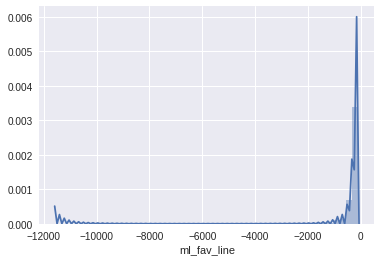

In [54]:
sns.distplot(_lines['ml_fav_line'])

In [56]:
c_lines = calc_concensus(_lines).dropna()

/home/ben/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ben/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [58]:
pd.to_pickle(c_lines, 'c_lines250.pkl')

In [59]:
c_lines.loc[:, ['bookie', 'fav', 'dog', 'line_datetime', 'ml_dog_line',
                'ml_fav_line', 'concensus_ml_fav', 'concensus_ml_dog', 'ml_dog_z', 'ml_fav_z',
               'ml_dog_std', 'ml_fav_std']].head()

,bookie,fav,dog,line_datetime,ml_dog_line,ml_fav_line,concensus_ml_fav,concensus_ml_dog,ml_dog_z,ml_fav_z,ml_dog_std,ml_fav_std
257,SPORTBET.COM LINE MOVEMENTS,WAS,PHI,2017-04-21 13:10:00,116.0,-130,0.568016,0.466223,-0.707107,-0.707107,0.004611,0.003958
4924,5DIMES LINE MOVEMENTS,ATL,CHI,2017-04-21 13:10:00,225.0,-265,0.723738,0.304904,0.707107,0.707107,0.003944,0.003238
2928,5DIMES LINE MOVEMENTS,HOU,JAC,2017-04-21 13:10:00,175.0,-210,0.674775,0.360390,0.707107,0.707107,0.004592,0.003739
2171,5DIMES LINE MOVEMENTS,DET,ARI,2017-04-21 13:11:00,130.0,-150,0.597571,0.431984,0.707107,0.707107,0.003958,0.003435
1145,5DIMES LINE MOVEMENTS,PIT,CLE,2017-04-21 13:11:00,400.0,-500,0.831197,0.197087,0.707107,0.707107,0.004119,0.003022


In [171]:
c_lines[c_lines.ml_fav_z <= -2].tail()

,index,bookie,date,dog,dog_spread_line,fav,fav_spread_line,game_datetime,game_uuid,line_datetime,...,ml_dog_prob,ml_fav_prob,over_prob,under_prob,concensus_ml_fav,concensus_ml_dog,ml_dog_std,ml_fav_std,ml_fav_z,ml_dog_z
219118,268024,PINNACLESPORTS LINE MOVEMENTS,12/31,CIN,-106.0,BAL,-104.0,2017-12-31 16:25:00,4ef74b40-fd47-11e7-be4d-c4b301d13749,2017-12-31 16:18:00,...,0.246914,0.777778,0.485437,0.539171,0.802561,0.234959,0.010047,0.011962,-2.071850,1.189949
218387,267215,THE GREEK LINE MOVEMENTS,12/31,STL,-105.0,SFO,-115.0,2017-12-31 16:25:00,4ef751da-fd47-11e7-b36f-c4b301d13749,2017-12-31 16:22:00,...,0.333333,0.705882,0.523810,0.523810,0.727482,0.307464,0.010638,0.008242,-2.620695,2.431799
220664,270085,YOUWAGER.EU LINE MOVEMENTS,12/31,KAN,-110.0,DEN,-110.0,2017-12-31 16:25:00,4ef744ba-fd47-11e7-b7c2-c4b301d13749,2017-12-31 16:22:00,...,0.434783,0.600000,0.523810,0.523810,0.622741,0.408153,0.012318,0.010409,-2.184730,2.161784
222890,272592,PINNACLESPORTS LINE MOVEMENTS,12/31,MIA,-108.0,BUF,-102.0,2017-12-31 16:25:00,4ef7313a-fd47-11e7-a892-c4b301d13749,2017-12-31 16:23:00,...,0.458716,0.565217,0.495050,0.530516,0.582223,0.453683,0.007638,0.007432,-2.288010,0.658872
223850,273962,PINNACLESPORTS LINE MOVEMENTS,12/31,TAM,-108.0,NOR,-102.0,2017-12-31 16:25:00,4ef729c6-fd47-11e7-8a41-c4b301d13749,2017-12-31 16:24:00,...,0.310559,0.714286,0.551570,0.473934,0.736348,0.297732,0.006849,0.009350,-2.359605,1.872635


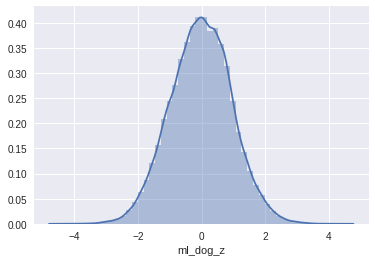

In [66]:
sns.distplot(c_lines['ml_dog_z'])

Exception in thread Thread-16:
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/py35/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/ben/anaconda3/envs/py35/lib/python3.5/site-packages/tqdm/_tqdm.py", line 106, in run
    if instance.miniters > 1 and \
AttributeError: 'tqdm_notebook' object has no attribute 'miniters'



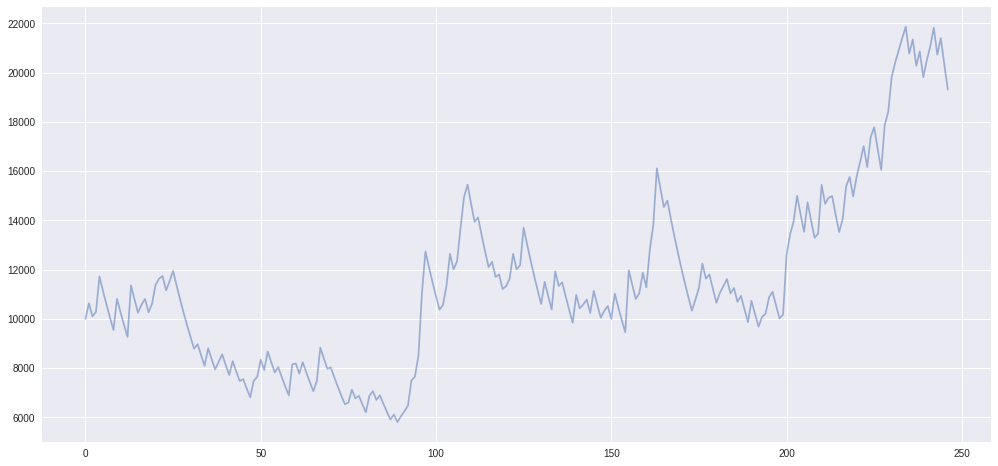

In [59]:
outcomes, probs, br = simulate_games(test, nba_games, nba_mapping, tol=-3., risk=.05, use_z=True)
fig, ax = plt.subplots(figsize=(17, 8))
ax.plot(range(len(br)), br, alpha=.5)

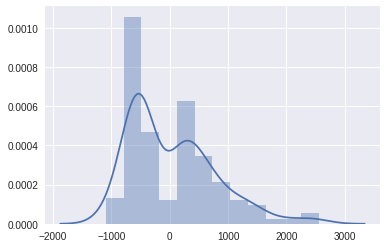

In [61]:
sns.distplot(outcomes)

In [64]:
len(nba_games)

10209

Exception in thread Thread-24:
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/py35/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/ben/anaconda3/envs/py35/lib/python3.5/site-packages/tqdm/_tqdm.py", line 106, in run
    if instance.miniters > 1 and \
AttributeError: 'tqdm_notebook' object has no attribute 'miniters'



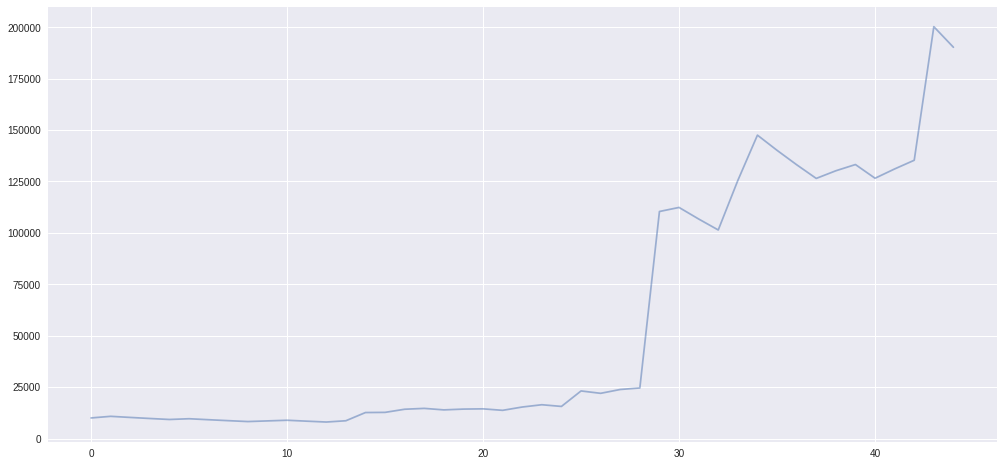

In [75]:
outcomes, probs, br = simulate_games(test, nba_games, nba_mapping, tol=.05, risk=.05, use_z=False)
fig, ax = plt.subplots(figsize=(17, 8))
ax.plot(range(len(br)), br, alpha=.5)

In [79]:
br

[10000.0,
 10790.0,
 10250.5,
 9737.9750000000004,
 9251.0762500000001,
 9618.1824503968255,
 9137.2733278769847,
 8680.409661483136,
 8246.3891784089792,
 8563.5579929631713,
 8880.7268075173633,
 8436.6904671414959,
 8014.8559437844215,
 8636.0072794277148,
 12630.160646163033,
 12709.099150201551,
 14234.191048225737,
 14652.84372611473,
 13920.201539808993,
 14306.873804803688,
 14426.097753177053,
 13704.7928655182,
 15315.106027216589,
 16425.45121418979,
 15604.178653480301,
 23133.194853784549,
 21976.535111095323,
 23844.540595538427,
 24589.682489149003,
 110407.67437627903,
 112379.23999014116,
 106760.2779906341,
 101422.26409110239,
 125510.05181273921,
 147537.06590587494,
 140160.21261058119,
 133152.20198005214,
 126494.59188104954,
 130215.02105402158,
 133243.27735760348,
 126581.11348972331,
 131101.86754292771,
 135330.96004431247,
 200289.82086558244,
 190275.32982230332]

In [66]:
import pymc3 as pm

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, cuDNN not available)


In [72]:
with pm.Model() as model:           
    mu = pm.Uniform('mu', -1000, 1000)
    sd = pm.HalfCauchy('sd', 3)
    returns = pm.Normal('returns', mu=mu, sd=sd, observed=np.array(outcomes))
    trace = pm.sample(10000, tune=2000, init='advi')

100%|██████████| 12000/12000 [00:46<00:00, 258.40it/s]


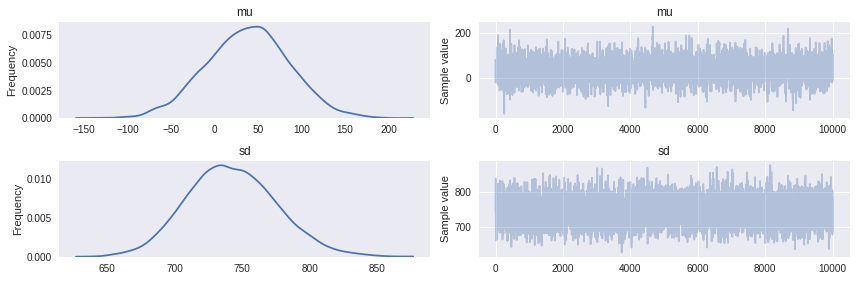

In [73]:
pm.traceplot(trace);

In [74]:
np.mean(trace['mu'] > 0)

0.78059999999999996

In [164]:
p_outcomes, p_probs = simulate_games(c_lines, games, tol=.05, use_z=False)

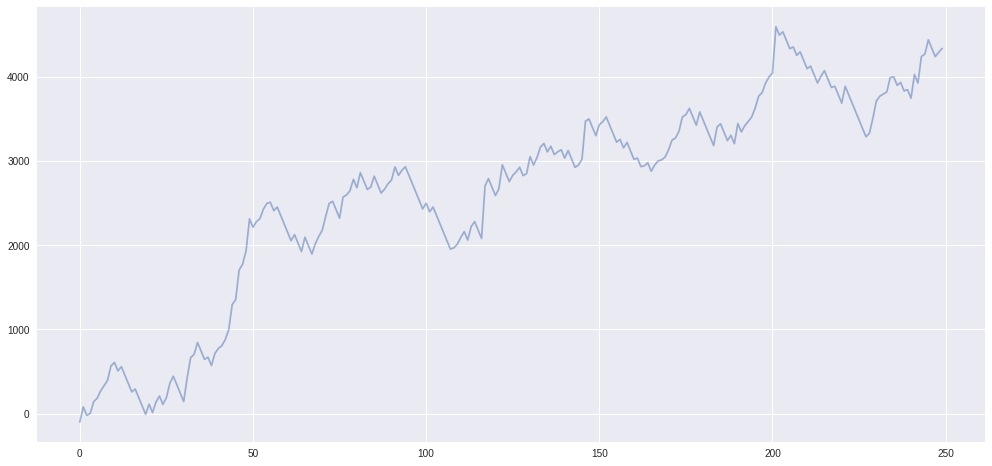

In [174]:
fig, ax = plt.subplots(figsize=(17, 8))
ax.plot(range(len(outcomes)), np.cumsum(outcomes), alpha=.5)
# ax.plot(range(len(p_outcomes)), np.cumsum(p_outcomes), alpha=.5)
# ax.scatter(range(len(outcomes)), np.cumsum(outcomes), c='blue')
# ax.scatter(range(len(p_outcomes)), np.cumsum(p_outcomes),c='green')
plt.savefig('results.png')

In [166]:
len(p_outcomes)

26

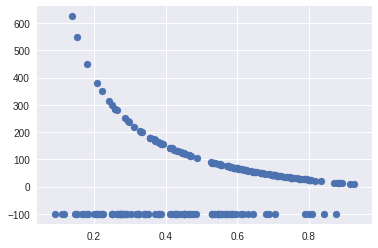

In [153]:
plt.scatter(probs, outcomes)

In [144]:
np.mean(outcomes)

17.359859774177909

In [145]:
np.mean(np.array(outcomes) > 0)

0.58399999999999996

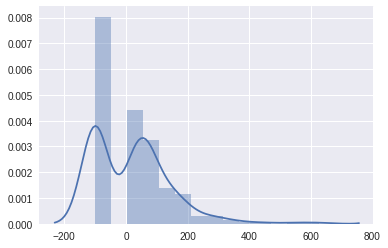

In [146]:
sns.distplot(outcomes)